In [1]:
import xcast as xc 
import xarray as xr 
import pandas as pd
import numpy as np
from dask.distributed import Client
import datetime as dt

In [ ]:
variables = ['tp', 't2m']
leads = [ [14, 28], [28, 42] ]

In [2]:
for v in range(len(variables)):
    var = variables[v]
    lead_low, lead_high = leads[v]
    
    print('{} LOADING INPUT DATA FOR {} FOR TARGET {}'.format(dt.datetime.now(), var.upper(), v))
    ecmwf = xr.open_dataset('s2s/preprocessed/precip/ecmwf-hcst-{}.nc'.format(var), chunks='auto').sel(forecast_time=slice(pd.Timestamp("1999-01-02"), pd.Timestamp("2010-12-31")))
    eccc = xr.open_dataset('s2s/preprocessed/precip/eccc-hcst-{}.nc'.format(var), chunks='auto').sel(forecast_time=ecmwf.forecast_time, method='ffill')
    ncep = xr.open_dataset('s2s/preprocessed/precip/ncep-hcst-{}.nc'.format(var), chunks='auto').sel(forecast_time=ecmwf.forecast_time, method='ffill')

    ncep.coords['forecast_time'] = ecmwf.coords['forecast_time'].values
    eccc.coords['forecast_time'] = ecmwf.coords['forecast_time'].values

    ncep_diffs = [pd.Timedelta(x) for x in ecmwf.forecast_time.values - ncep.forecast_time.values] 
    eccc_diffs = [pd.Timedelta(x) for x in ecmwf.forecast_time.values - eccc.forecast_time.values] 

    ecmwf = ecmwf.sel(lead_time=slice(pd.Timedelta(days=lead_low), pd.Timedelta(days=lead_high))).mean('lead_time')
    eccc = xr.concat([eccc.isel(forecast_time=i).sel(lead_time=slice(pd.Timedelta(days=lead_low)+eccc_diffs[i],pd.Timedelta(days=lead_high)+eccc_diffs[i] )) for i in range(len(eccc_diffs))], 'forecast_time').mean('lead_time') 
    ncep = xr.concat([ncep.isel(forecast_time=i).sel(lead_time=slice(pd.Timedelta(days=lead_low)+ncep_diffs[i],pd.Timedelta(days=lead_high)+ncep_diffs[i] )) for i in range(len(ncep_diffs))], 'forecast_time').mean('lead_time') 

    obs = xr.open_dataset('s2s/preprocessed/precip/obs-hcst-{}.nc'.format(var), chunks='auto').sel(forecast_time=ecmwf.forecast_time, method='ffill')
    obs.coords['forecast_time'] = ecmwf.coords['forecast_time']
    obs_diffs = [pd.Timedelta(x) for x in ecmwf.forecast_time.values - obs.forecast_time.values] 
    obs = xr.concat([obs.isel(forecast_time=i).sel(lead_time=slice(pd.Timedelta(days=lead_low)+obs_diffs[i],pd.Timedelta(days=lead_high)+obs_diffs[i] )) for i in range(len(obs_diffs))], 'forecast_time').mean('lead_time')


    if var == 't2m':
        X = xr.concat([ecmwf.tp, eccc.tp, ncep.tp], 'M').assign_coords({'M':[0,1,2]}) # for mean t2m 
        Y = obs.expand_dims({'M':[0]}).tp

    elif var == 'tp':
        X = xr.concat([ecmwf.tp, eccc.tp, ncep.tp], 'M').assign_coords({'M':[0,1,2]}) * (lead_high - lead_low) #for total precip
        Y = obs.expand_dims({'M':[0]}).tp * (lead_high - lead_low)

    X = X.chunk({'latitude': 11, 'longitude': 24, 'forecast_time': 583, 'M':1}).fillna(1)
    Y = Y.chunk({'latitude': 11, 'longitude': 24, 'forecast_time': 583, 'M':1}).fillna(1)

    print('{} STARTING POELM CROSS VALIDATION FOR {} FOR TARGET {}'.format(dt.datetime.now(), var.upper(), v))

    poelm_hindcasts = xc.cross_validate(xc.PoelmMME, X, Y,  x_sample_dim='forecast_time', x_lat_dim='latitude', x_lon_dim='longitude', y_sample_dim='forecast_time', y_lat_dim='latitude', y_lon_dim='longitude', ND=5, hidden_layer_size=5, window=53, verbose=True)
    climatology_hcsts = xr.ones_like(poelm_hindcasts.hindcasts) * 0.33
    print('\n{} FINISHED POELM CROSS VALIDATION FOR {} FOR TARGET {}'.format(dt.datetime.now(), var.upper(), v))
    
    print('{} CALCULATING POELM RPSS {} FOR TARGET {}'.format(dt.datetime.now(), var.upper(), v))
    oh = xc.RankedTerciles()
    oh.fit(Y, x_sample_dim='forecast_time', x_lat_dim='latitude', x_lon_dim='longitude')
    YP = oh.transform(Y, x_sample_dim='forecast_time', x_lat_dim='latitude', x_lon_dim='longitude')
    
    poelm_rps = xc.RankProbabilityScore(poelm_hindcasts.hindcasts, YP, x_sample_dim='forecast_time', x_lat_dim='latitude', x_lon_dim='longitude', x_feature_dim='C', y_sample_dim='forecast_time', y_lat_dim='latitude', y_lon_dim='longitude', y_feature_dim='C', rechunk=True, lat_chunks=11, lon_chunks=24, verbose=True)
    print('\n{} FINISHED CALCULATING POELM RPSS {} FOR TARGET {}'.format(dt.datetime.now(), var.upper(), v))

    climatology_rps = xc.RankProbabilityScore(xr.ones_like(poelm_hindcasts.hindcasts) * 0.33, YP, x_sample_dim='forecast_time', x_lat_dim='latitude', x_lon_dim='longitude', x_feature_dim='C', y_sample_dim='forecast_time', y_lat_dim='latitude', y_lon_dim='longitude', y_feature_dim='C', rechunk=True, lat_chunks=11, lon_chunks=24, verbose=True)                  
    poelm_rpss = (1 - poelm_rps / climatology_rps)
    print('{} SAVING POELM HINDCASTS AND RPSS VS CLIMO) {} FOR TARGET {}'.format(dt.datetime.now(), var.upper(), v))
    poelm_hindcasts.to_netcdf('s2s/output/POELM_XVAL_HCSTS_ND5_HL5_L1YO_{}_{}-{}.nc'.format(var.upper(), lead_low, lead_high))
    poelm_rpss.to_netcdf('s2s/output/POELM_RPSS_VS_CLIMO33_ND5_HL5_L1YO_{}_{}-{}.nc'.format(var.upper(), lead_low, lead_high))
    
    
    

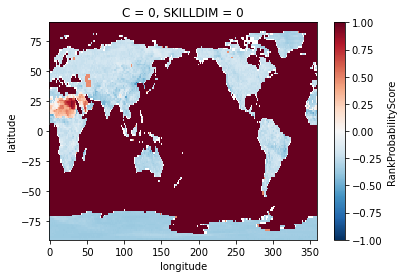

In [38]:
(1 - poelm_rps / elr_rps).plot(vmax=1)